In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torchvision.transforms as transforms
from Anchor.anchor import Anchor, Tasktype
from torchvision.models import inception_v3, resnet18
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

%load_ext autoreload
%autoreload 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([162])
tensor(162)
beagle 0.9371578097343445
tensor(166)
Walker hound 0.02404695749282837
tensor(167)
English foxhound 0.012306500226259232
tensor(161)
basset 0.0020380292553454638
tensor(163)
bloodhound 0.0010032199788838625


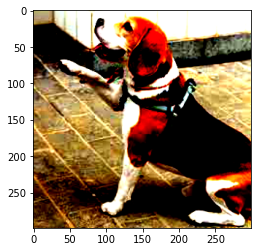

In [2]:

# model:c, h, w
# numpy, sklearn matplotlib: w, h, c
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# c, h, w

image = Image.open("../static/dog_paper.jpeg")
input = preprocess(image).unsqueeze(0)
# b, c, h, w

model = inception_v3(pretrained=True)
model.eval()

plt.imshow(input.squeeze().permute(1,2,0))
# h w c

with torch.no_grad():
    output = model(input)

print(torch.argmax(output, dim=1))
probs = torch.nn.functional.softmax(output[0], dim=0)

with open("../static/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probs, 5)
    top5_prob, top5_catid = top5_prob.squeeze(), top5_catid.squeeze()
    for i in range(top5_prob.size(0)):
        print(top5_catid[i])
        print(categories[top5_catid[i]], top5_prob[i].item())

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

explainer = Anchor(Tasktype.IMAGE)

def predict(x):
    test = x.to(device)
    return model(test)

anchor, segments = explainer.explain_instance(input.squeeze().permute(1,2,0), predict, "greedy", 10000)
# h w c

INFO: Start Sampling
INFO: Start greedy search
INFO:test
/home/kevin/iml-ws21-projects-risingnumpygods/Anchor/bandit.py:100: RuntimeWarning: divide by zero encountered in double_scalars
  lb[f] = KL_LUCB.dlow_bernoulli(means[f], beta / candidates[f].n_samples)
/home/kevin/iml-ws21-projects-risingnumpygods/Anchor/bandit.py:102: RuntimeWarning: divide by zero encountered in double_scalars
  ub[f] = KL_LUCB.dup_bernoulli(means[f], beta / candidates[f].n_samples)
INFO:1.0
INFO:0.8886216193437576
INFO:0.8944525271654129
INFO:0.8251139901913955
INFO:0.8296359442242296
INFO:0.591637879081137
INFO:0.5291045827992896
INFO:0.683169511955162
INFO:0.6855171866990644
INFO:0.5874977873049132
INFO:0.5892228245405017
INFO:0.4850070634106205
INFO:0.4113664549577887
INFO:0.3878354119545011
INFO:0.3431475155815882
INFO:0.33068866452943113
INFO:0.30003844643129507
INFO:0.8533495946601635
INFO:0.3104258816938552
INFO:0.8551414702549053
INFO:0.6204786749245771
INFO:0.4767546660888904
INFO:0.4957817564461115

AnchorCandidate(_feature_mask=[11, 19], _precision=1.0, _n_samples=210, _positive_samples=210, _coverage=0.2485)


[11, 19]
1.0
[[ 1  1  1 ...  6  6  6]
 [ 1  1  1 ...  6  6  6]
 [ 1  1  1 ...  6  6  6]
 ...
 [62 62 62 ... 63 63 63]
 [62 62 62 ... 63 63 63]
 [62 62 62 ... 63 63 63]]
[11, 19]
[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [298 296]
 [298 297]
 [298 298]]


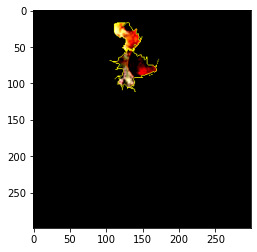

In [17]:
print(anchor.feature_mask)
print(anchor.precision)

print(segments)
print(anchor.feature_mask)
idxs = np.argwhere(~np.isin(segments,anchor.feature_mask))
print(idxs)
# input[:, idxs[:, 0], idxs[:, 1]] = 0
# plt.imshow(input.squeeze().permute(2,1,0))

img = mark_boundaries(input.squeeze().permute(1,2,0), segments)
img[idxs[:, 0], idxs[:, 1], :] = 0
plt.imshow(img)

In [16]:
# #h, w, c
# img.shape
print(input.shape)
model.to(device)
input[:,:, idxs[:, 0], idxs[:, 1]] = 0.34

output = model(input.to(device))
print(torch.argmax(output, dim=1))
probs = torch.nn.functional.softmax(output[0], dim=0)
print(probs[162])


torch.Size([1, 3, 299, 299])
tensor([733], device='cuda:0')
tensor(0.0019, device='cuda:0', grad_fn=<SelectBackward0>)


In [6]:
test = np.ones((5,))

feature_vec = [1]
print(np.isin(feature_vec, np.where(test == 1)))
                                                                                                                       
test = np.array([0, 1, 0, 1])
feature_vec = [2, 3]
np.all(np.isin(feature_vec, np.where(test == 1)), axis=0)


[ True]


False